# Производственный процесс обработки стали

**Задача:** создать модель, которая научится предсказывать температуру стали <br>
**Точность предсказаний модели**: 6.0<MAE<8.7

Данные хранятся: /datasets/final_steel/
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


**Описание процесса**
*сталь обрабатывают в ковше на 100 тонн, облицованном огнеупорным кирпичом.*


Этап 1: сталь заливают в ковш и подогревают электродами, встроенными в ковш <br>


Этап 2: обработка:<br>
2.1. измерение температуры стали<br>
2.2. определение химического составка<br>
2.3. повышение температуры<br>
2.4. добавление легирующих материалов (проволоки и прочего)<br>
2.5. продувка интерным газом.<br>
2.6. перемешивание сырья <br>


**План работ:** <br>
>    0. постановка задачи: что нам надо определить, в каком виде, кто это будет использовать и проверять, какие данные нам нужны, а какие лишние.<br>
>    1. Импорт данных<br>
>    2. Исследовательский анализ данных 
>>        2.1. поиск пропусков <br>
>>        2.2. поиск дубликатов <br>
>>        2.3. поиск корреляций <br>
>>        2.4. поиск выбивающихся решений <br>
>>        2.5. анализ временного интервала, с которым мы работаем <br>
>    3. определение целевого признака и характеристик<br>
>    4. разделение данных на тестовую и учебную выборку.<br>
>    5. предложение 2 моделей и анализ трех моделей.<br>
>    6. тестирование наилучшей модели на тестовой выборке. <br>
>    7. Отчет. <br>

In [1]:
!pip install pandas-profiling

In [2]:
#Импорт библиотек для дальнейшей работы
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from catboost import Pool, cv



pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500) 
pd.options.display.float_format = '{:,.3f}'.format



### Импорт данных

In [4]:
# Импортируем данные по температуре:

try:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
except:
    data_temp = pd.read_csv('data_temp.csv')

In [5]:
# Импортируем данные по электродам:

try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
except:
    data_arc = pd.read_csv('data_arc.csv')

In [6]:
# Импортируем данные по легирующим элементам:

try:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
except:
    data_bulk = pd.read_csv('data_bulk.csv')

In [7]:
# Импортируем данные по времени добавления легирующих элементов:

try:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
except:
    data_bulk_time = pd.read_csv('data_bulk_time.csv')

In [8]:
# Импортируем данные по  добавлению газа

try:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
except:
    data_gas = pd.read_csv('data_gas.csv')

In [9]:
# Импортируем данные по  добавлению проволоки

try:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
except:
    data_wire = pd.read_csv('data_wire.csv')

In [10]:
# Импортируем данные по  времени добавления проволоки

try:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_wire_time = pd.read_csv('data_wire_time.csv')

### Проведем короткий исследовательскй анализ всех файлов

### Исследуем файл с температурой

In [11]:
#Посмотрим на файл с температурой:
data_temp.head()

key         Время замера  Температура
0    1  2019-05-03 11:16:18    1,571.000
1    1  2019-05-03 11:25:53    1,604.000
2    1  2019-05-03 11:29:11    1,618.000
3    1  2019-05-03 11:30:01    1,601.000
4    1  2019-05-03 11:30:39    1,613.000

В файле представлено для каждой партии (key) время замера температуры и показатели измеренной температуры. 

In [12]:
#Посмотрим общую информацию о файле
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Представлено 15 907 значений времени замера и 13 000 замеров температуры. Надо будет убрать те партии из файла,в которых отсутствует последний замер температуры. 

In [13]:
#Переименуем названия столбцов
data_temp.columns = ['key', 'measure_time', 'measured_temperature']

In [14]:
#Преобразуем значения времени в значение date_time
data_temp['measure_time'] = pd.to_datetime(data_temp['measure_time'], format = '%Y-%m-%d %H:%M:%S')

In [15]:
data_temp.profile_report()

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
data_temp.describe()

key  measured_temperature
count 15,907.000            13,006.000
mean   1,607.881             1,591.841
std      942.212                21.376
min        1.000             1,191.000
25%      790.000             1,581.000
50%    1,618.000             1,591.000
75%    2,427.000             1,601.000
max    3,241.000             1,705.000

Наиболее часто встрачается значение температуры в 1591 градус. 

In [17]:
#отсортируем значения по времени
data_temp = data_temp.sort_values(by = ['measure_time'])

In [18]:
#теперь посмотрим на те строки, где встречаются пропуски в измеренной температуре
missed_temp_keys = data_temp.loc[data_temp['measured_temperature'].isna()]['key']

In [19]:
missed_temp_keys = missed_temp_keys.unique()

In [20]:
missed_temp_keys

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

Значения температуры пропущены для всех партий с 2500 по 3241. Теперь надо понять: для этих партий пропущены все значения температуры или только некоторые. 

In [21]:
data_temp.loc[(data_temp['key'] >= 2500) & (data_temp['key'] <= 3241)] 

key        measure_time  measured_temperature
12267  2500 2019-08-06 03:11:31             1,539.000
12268  2500 2019-08-06 03:24:43                   NaN
12269  2500 2019-08-06 03:25:16                   NaN
12270  2500 2019-08-06 03:28:21                   NaN
12271  2501 2019-08-06 03:44:42             1,587.000
...     ...                 ...                   ...
15902  3241 2019-09-01 04:03:30             1,586.000
15903  3241 2019-09-01 04:16:12                   NaN
15904  3241 2019-09-01 04:22:39                   NaN
15905  3241 2019-09-01 04:33:42                   NaN
15906  3241 2019-09-01 04:38:08                   NaN

[3640 rows x 3 columns]

Во всей таблице нас будут интересовать в качестве целевой метрики - последние замеры температуры (именно ее нам надо будет предсказывать). Создадим сводную таблицу, где будет key, количество итераций и последний замер температуры.

In [22]:
temp_stats  = pd.pivot_table(data_temp, index = 'key', values = 'measure_time', aggfunc = ['count', max, min]).reset_index()            

In [23]:
temp_stats.columns = ['key', 'count', 'max_time', 'min_time']

In [24]:
#Добавим значение  температуры, замеренной в максимальное  время. 

for i in temp_stats['key']:
    time = temp_stats.loc[temp_stats['key'] == i]['max_time'].to_string(index = False)
    temp_stats.loc[temp_stats['key'] == i, 'final_temperature'] = data_temp.loc[(data_temp['key'] == i) & (data_temp['measure_time'] == time)]['measured_temperature'].values.copy()

In [25]:
#Добавим значение  температуры, замеренной в минимальное время. 

for i in temp_stats['key']:
    time = temp_stats.loc[temp_stats['key'] == i]['min_time'].to_string(index = False)
    temp_stats.loc[temp_stats['key'] == i, 'starting_temperature'] = data_temp.loc[(data_temp['key'] == i) & (data_temp['measure_time'] == time)]['measured_temperature'].values.copy()

In [26]:
temp_stats

key  count            max_time            min_time  final_temperature  \
0        1      5 2019-05-03 11:30:39 2019-05-03 11:16:18          1,613.000   
1        2      6 2019-05-03 11:59:12 2019-05-03 11:37:27          1,602.000   
2        3      5 2019-05-03 12:34:57 2019-05-03 12:13:17          1,599.000   
3        4      3 2019-05-03 12:59:25 2019-05-03 12:52:57          1,625.000   
4        5      2 2019-05-03 13:36:01 2019-05-03 13:23:19          1,602.000   
...    ...    ...                 ...                 ...                ...   
3211  3237      5 2019-08-31 23:05:43 2019-08-31 22:44:04                NaN   
3212  3238      3 2019-08-31 23:43:00 2019-08-31 23:30:31                NaN   
3213  3239      8 2019-09-01 02:24:15 2019-09-01 01:31:47                NaN   
3214  3240      8 2019-09-01 03:35:16 2019-09-01 02:39:01                NaN   
3215  3241      5 2019-09-01 04:38:08 2019-09-01 04:03:30                NaN   

      starting_temperature  
0                1,571.000  
1                1,581.000  
2                1,596.000  
3                1,601.000  
4                1,576.000  
...                    ...  
3211             1,569.000  
3212             1,584.000  
3213             1,598.000  
3214             1,617.000  
3215             1,586.000  

[3216 rows x 6 columns]

In [27]:
#Удалим все включи, в которых отсутствуют последние значения температуры
temp_stats_final = temp_stats.drop(temp_stats.loc[temp_stats['final_temperature'].isna()].index)

In [28]:
temp_stats_final

key  count            max_time            min_time  final_temperature  \
0        1      5 2019-05-03 11:30:39 2019-05-03 11:16:18          1,613.000   
1        2      6 2019-05-03 11:59:12 2019-05-03 11:37:27          1,602.000   
2        3      5 2019-05-03 12:34:57 2019-05-03 12:13:17          1,599.000   
3        4      3 2019-05-03 12:59:25 2019-05-03 12:52:57          1,625.000   
4        5      2 2019-05-03 13:36:01 2019-05-03 13:23:19          1,602.000   
...    ...    ...                 ...                 ...                ...   
2472  2495      3 2019-08-06 00:54:42 2019-08-06 00:35:45          1,591.000   
2473  2496      4 2019-08-06 01:29:52 2019-08-06 01:02:54          1,591.000   
2474  2497      2 2019-08-06 01:53:50 2019-08-06 01:41:53          1,589.000   
2475  2498      5 2019-08-06 02:25:31 2019-08-06 02:03:49          1,594.000   
2476  2499      3 2019-08-06 03:00:28 2019-08-06 02:40:25          1,603.000   

      starting_temperature  
0                1,571.000  
1                1,581.000  
2                1,596.000  
3                1,601.000  
4                1,576.000  
...                    ...  
2472             1,570.000  
2473             1,554.000  
2474             1,571.000  
2475             1,591.000  
2476             1,569.000  

[2477 rows x 6 columns]

In [29]:
temp_stats_final['procedure_time'] = temp_stats_final['max_time'] - temp_stats_final['min_time']

In [30]:
temp_stats_final.describe()

key     count  final_temperature  starting_temperature  \
count 2,477.000 2,477.000          2,477.000             2,477.000   
mean  1,249.969     4.952          1,595.334             1,588.406   
std     720.074     1.810             16.019                29.233   
min       1.000     1.000          1,541.000             1,191.000   
25%     628.000     4.000          1,587.000             1,572.000   
50%   1,251.000     5.000          1,593.000             1,588.000   
75%   1,872.000     6.000          1,599.000             1,605.000   
max   2,499.000    16.000          1,700.000             1,679.000   

                  procedure_time  
count                       2477  
mean   0 days 00:30:53.456197012  
std    0 days 00:21:41.783213493  
min              0 days 00:00:00  
25%              0 days 00:19:41  
50%              0 days 00:26:31  
75%              0 days 00:37:42  
max              0 days 06:32:17

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4358338670>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4358338220>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4368541e50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f43583385b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4374bd2160>],
 'means': []}

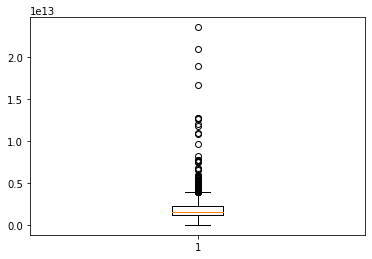

In [275]:
plt.boxplot(temp_stats_final['procedure_time'].values)

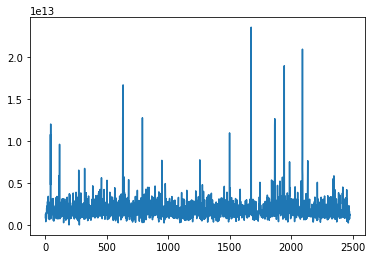

In [276]:
plt.plot(temp_stats_final['procedure_time'].values)

Само время выплавки имеет много различных выбросов. Оно колеблется довольно сильно. 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f435839c6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4374edfe80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f435839c820>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4374edf2e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4374f67490>],
 'means': []}

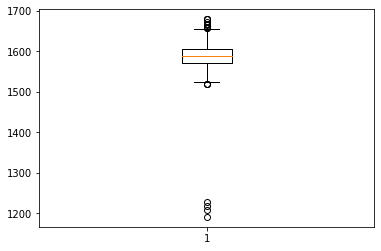

In [277]:
#Посмотрим на то, как выглядит стартовая и финальная температура процесса
plt.boxplot(temp_stats_final['starting_temperature'].values)

В стартовой температуре смеси есть выбросы. Поскольку из стали с начальной температурой выбросов все же получился хороший итоговый результат, мы не будем убирать данные, которые находятся ниже 1500 градусов. 

{'whiskers': [<matplotlib.lines.Line2D at 0x2405850bfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x2405851c670>,
 'boxes': [<matplotlib.lines.Line2D at 0x2405850bd00>],
 'medians': [<matplotlib.lines.Line2D at 0x2405851cb50>],
 'fliers': [<matplotlib.lines.Line2D at 0x2405851ce20>],
 'means': []}

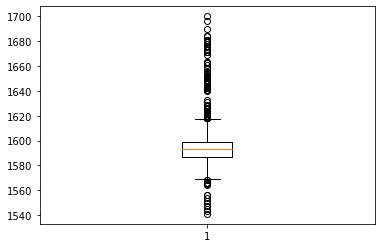

In [31]:
plt.boxplot(temp_stats_final['final_temperature'].values)

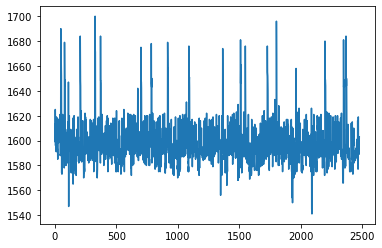

In [32]:
plt.plot(temp_stats_final['final_temperature'].values)

<AxesSubplot:xlabel='key', ylabel='max_time'>

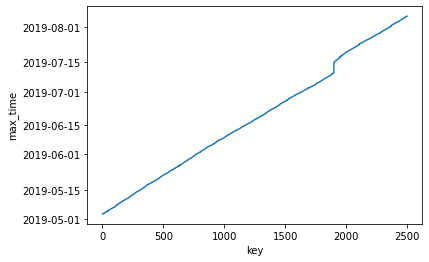

In [33]:
#На всякий случай, посомтрим, как партии распределены во времени
sns.lineplot(data=temp_stats_final, x="key", y="max_time")

#Если не брать "скачок" в районе 2000й партии (обусловленный тем, что мы удаляли партии, где температура неизвестна, партии идут равномерно во ремнеи, одна за другой)

Финальная температура нам известна для 2 477 партий (key). Нормальные значения (между 1 и 3 квартилем колбятся для финальной температуры от 1 587 до 1 599 градусов.) В седнем для выполнения работ требуется 5 итераций (обычно от 4 до 6). На сам процесс выплавки уходит в норме около получаса: от 19 до 37 минут.

In [34]:
#В отдельную переменную выведем партии, которые будем брать в работу
final_keys = temp_stats_final['key']

### Исследуем файл с данными о нагреве сырья

In [35]:
data_arc

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0         1  2019-05-03 11:02:14  2019-05-03 11:06:02              0.976   
1         1  2019-05-03 11:07:28  2019-05-03 11:10:33              0.806   
2         1  2019-05-03 11:11:44  2019-05-03 11:14:36              0.744   
3         1  2019-05-03 11:18:14  2019-05-03 11:24:19              1.659   
4         1  2019-05-03 11:26:09  2019-05-03 11:28:37              0.693   
...     ...                  ...                  ...                ...   
14871  3241  2019-09-01 03:58:58  2019-09-01 04:01:35              0.534   
14872  3241  2019-09-01 04:05:04  2019-09-01 04:08:04              0.677   
14873  3241  2019-09-01 04:16:41  2019-09-01 04:19:45              0.734   
14874  3241  2019-09-01 04:31:51  2019-09-01 04:32:48              0.221   
14875  3241  2019-09-01 04:34:47  2019-09-01 04:36:08              0.307   

       Реактивная мощность  
0                    0.687  
1                    0.520  
2                    0.499  
3                    1.063  
4                    0.414  
...                    ...  
14871                0.354  
14872                0.524  
14873                0.476  
14874                0.146  
14875                0.197  

[14876 rows x 5 columns]

Нас будет интересовать в этой таблице в качестве features для построения модели активная и реактивная мощность, а также начало и конец нагрева дугой. Мы будем считать время первого нагрева началом всего процесса, от которого будем после считать временные промежутки (время добавления элемента от первого нагрева, например)

In [36]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Заметим, что строк тут не 3,5 тыс, а 14 тысяч: потому что в одной партии могло быть несколько нагревов. 

In [37]:
#Переименуем названия столбцов
data_arc.columns = ['key', 'heating_starting_time', 'heating_end_time', 'active_power', 'reactive_power']


In [38]:
data_arc.head()

key heating_starting_time     heating_end_time  active_power  \
0    1   2019-05-03 11:02:14  2019-05-03 11:06:02         0.976   
1    1   2019-05-03 11:07:28  2019-05-03 11:10:33         0.806   
2    1   2019-05-03 11:11:44  2019-05-03 11:14:36         0.744   
3    1   2019-05-03 11:18:14  2019-05-03 11:24:19         1.659   
4    1   2019-05-03 11:26:09  2019-05-03 11:28:37         0.693   

   reactive_power  
0           0.687  
1           0.520  
2           0.499  
3           1.063  
4           0.414

In [39]:
#Преобразуем время в тим дата-время:
data_arc['heating_starting_time'] = pd.to_datetime(data_arc['heating_starting_time'], format = '%Y-%m-%d %H:%M:%S')
data_arc['heating_end_time'] = pd.to_datetime(data_arc['heating_end_time'], format = '%Y-%m-%d %H:%M:%S')


In [40]:
##
#добавим столбец с длительностью нагрева
data_arc['heating_period'] = (data_arc['heating_end_time']  - data_arc['heating_starting_time']).dt.seconds

In [41]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    14876 non-null  int64         
 1   heating_starting_time  14876 non-null  datetime64[ns]
 2   heating_end_time       14876 non-null  datetime64[ns]
 3   active_power           14876 non-null  float64       
 4   reactive_power         14876 non-null  float64       
 5   heating_period         14876 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 697.4 KB


In [42]:
#посмотим, как выглядит наша таблица при сортировке по key
data_arc.sort_values(by = 'key')

key heating_starting_time    heating_end_time  active_power  \
0         1   2019-05-03 11:02:14 2019-05-03 11:06:02         0.976   
1         1   2019-05-03 11:07:28 2019-05-03 11:10:33         0.806   
2         1   2019-05-03 11:11:44 2019-05-03 11:14:36         0.744   
3         1   2019-05-03 11:18:14 2019-05-03 11:24:19         1.659   
4         1   2019-05-03 11:26:09 2019-05-03 11:28:37         0.693   
...     ...                   ...                 ...           ...   
14873  3241   2019-09-01 04:16:41 2019-09-01 04:19:45         0.734   
14874  3241   2019-09-01 04:31:51 2019-09-01 04:32:48         0.221   
14871  3241   2019-09-01 03:58:58 2019-09-01 04:01:35         0.534   
14872  3241   2019-09-01 04:05:04 2019-09-01 04:08:04         0.677   
14875  3241   2019-09-01 04:34:47 2019-09-01 04:36:08         0.307   

       reactive_power  heating_period  
0               0.687             228  
1               0.520             185  
2               0.499             172  
3               1.063             365  
4               0.414             148  
...               ...             ...  
14873           0.476             184  
14874           0.146              57  
14871           0.354             157  
14872           0.524             180  
14875           0.197              81  

[14876 rows x 6 columns]

Выведем финальную таблицу, где будут каждой партии key соответствовать время первого нагрева, среднее время нагрева, среднее значение активной и реактивной мощности, количество нагревов.

In [43]:
arc_stat2 = pd.pivot_table(data = data_arc, index = 'key', values = ['heating_starting_time', 'active_power', 'reactive_power', 'heating_period'], 
                           aggfunc={'heating_starting_time': [min, len], 'active_power':np.mean, 'reactive_power': np.mean, 'heating_period':np.mean}).reset_index()

In [44]:
arc_stat2 = pd.pivot_table(data = data_arc, index = 'key', values = ['heating_starting_time', 'active_power', 'reactive_power', 'heating_period'], aggfunc = 
                                    {'heating_starting_time' : [min, 'count'], 'active_power': 'mean', 'active_power': 'mean', 'reactive_power': 'mean', 'heating_period' : 'mean'}).reset_index()

In [45]:
arc_stat2

key active_power heating_period heating_starting_time  \
                   mean           mean                 count   
0        1        0.976        219.600                     5   
1        2        0.763        202.750                     4   
2        3        0.505        131.000                     5   
3        4        0.802        185.250                     4   
4        5        0.837        217.250                     4   
...    ...          ...            ...                   ...   
3209  3237        0.786        181.800                     5   
3210  3238        0.702        182.000                     3   
3211  3239        0.583        152.000                     8   
3212  3240        0.597        167.800                     5   
3213  3241        0.494        131.800                     5   

                         reactive_power  
                     min           mean  
0    2019-05-03 11:02:14          0.637  
1    2019-05-03 11:34:14          0.500  
2    2019-05-03 12:06:54          0.320  
3    2019-05-03 12:39:37          0.515  
4    2019-05-03 13:11:13          0.563  
...                  ...            ...  
3209 2019-08-31 22:41:18          0.566  
3210 2019-08-31 23:26:18          0.560  
3211 2019-09-01 01:26:53          0.389  
3212 2019-09-01 02:35:24          0.497  
3213 2019-09-01 03:58:58          0.339  

[3214 rows x 6 columns]

In [46]:
arc_stat2.head()

key active_power heating_period heating_starting_time                      \
              mean           mean                 count                 min   
0   1        0.976        219.600                     5 2019-05-03 11:02:14   
1   2        0.763        202.750                     4 2019-05-03 11:34:14   
2   3        0.505        131.000                     5 2019-05-03 12:06:54   
3   4        0.802        185.250                     4 2019-05-03 12:39:37   
4   5        0.837        217.250                     4 2019-05-03 13:11:13   

  reactive_power  
            mean  
0          0.637  
1          0.500  
2          0.320  
3          0.515  
4          0.563

In [47]:
arc_stat2.columns = ['key', 'mean_a_power', 'mean_heat_period', 'amount_h_periods', 'heating_first_start_time', 'mean_r_power']

In [48]:
arc_stat2

key  mean_a_power  mean_heat_period  amount_h_periods  \
0        1         0.976           219.600                 5   
1        2         0.763           202.750                 4   
2        3         0.505           131.000                 5   
3        4         0.802           185.250                 4   
4        5         0.837           217.250                 4   
...    ...           ...               ...               ...   
3209  3237         0.786           181.800                 5   
3210  3238         0.702           182.000                 3   
3211  3239         0.583           152.000                 8   
3212  3240         0.597           167.800                 5   
3213  3241         0.494           131.800                 5   

     heating_first_start_time  mean_r_power  
0         2019-05-03 11:02:14         0.637  
1         2019-05-03 11:34:14         0.500  
2         2019-05-03 12:06:54         0.320  
3         2019-05-03 12:39:37         0.515  
4         2019-05-03 13:11:13         0.563  
...                       ...           ...  
3209      2019-08-31 22:41:18         0.566  
3210      2019-08-31 23:26:18         0.560  
3211      2019-09-01 01:26:53         0.389  
3212      2019-09-01 02:35:24         0.497  
3213      2019-09-01 03:58:58         0.339  

[3214 rows x 6 columns]

In [49]:
arc_stat2

key  mean_a_power  mean_heat_period  amount_h_periods  \
0        1         0.976           219.600                 5   
1        2         0.763           202.750                 4   
2        3         0.505           131.000                 5   
3        4         0.802           185.250                 4   
4        5         0.837           217.250                 4   
...    ...           ...               ...               ...   
3209  3237         0.786           181.800                 5   
3210  3238         0.702           182.000                 3   
3211  3239         0.583           152.000                 8   
3212  3240         0.597           167.800                 5   
3213  3241         0.494           131.800                 5   

     heating_first_start_time  mean_r_power  
0         2019-05-03 11:02:14         0.637  
1         2019-05-03 11:34:14         0.500  
2         2019-05-03 12:06:54         0.320  
3         2019-05-03 12:39:37         0.515  
4         2019-05-03 13:11:13         0.563  
...                       ...           ...  
3209      2019-08-31 22:41:18         0.566  
3210      2019-08-31 23:26:18         0.560  
3211      2019-09-01 01:26:53         0.389  
3212      2019-09-01 02:35:24         0.497  
3213      2019-09-01 03:58:58         0.339  

[3214 rows x 6 columns]

In [50]:
#теперь оставим в данных только те партии, которые мы оставили в предыдущей таблице с температурой
arc_stat2  = arc_stat2.loc[arc_stat2['key'].isin(final_keys.values)].reset_index()

In [51]:
arc_stat2.profile_report()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

У нас reactive_power в может колебаться где-то от 0 до 2 единиц. Между тем, есть серьезные выбросы (ошибочиые?) значения. При этом наблюдается сильная корреляция между реактивной и активной мощностью. Заменим одну и другую на полную мощность (корень из суммы квадратов реактивной и активной мощностей) (сделаем это в самом конце работы при сведении финальной таблицы).
Но сначала посмотрим на "выбросы" в реактивной мощности.


In [52]:
arc_stat2.loc[(arc_stat2['mean_r_power'] <0) | (arc_stat2['mean_r_power'] >2)]

df_index   key  mean_a_power  mean_heat_period  amount_h_periods  \
2097      2097  2116         0.462           108.250                 4   

     heating_first_start_time  mean_r_power  
2097      2019-07-24 00:29:52      -178.648

In [53]:
#Поскольку такое "странное" значение только одно, просто уберем cnhjre 2097
arc_stat2 = arc_stat2.drop(arc_stat2.loc[(arc_stat2['mean_r_power'] <0) | (arc_stat2['mean_r_power'] >2)].index)

### Исследуем файл с добавлением легирующих веществ

In [54]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN  43.000     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN  73.000     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN  34.000     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN  81.000     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN  78.000     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN  206.000      NaN  150.000  154.000  
1     NaN      NaN      NaN  206.000      NaN  149.000  154.000  
2     NaN      NaN      NaN  205.000      NaN  152.000  153.000  
3     NaN      NaN      NaN  207.000      NaN  153.000  154.000  
4     NaN      NaN      NaN  203.000      NaN  151.000  152.000

Мы видим столбец партии (key) и количество легирующих веществ, которые добавлялись или не добавлялись на данном этапе. Заменим все "пропущенные" величины на нули.  

In [55]:
data_bulk.isna().mean()

key       0.000
Bulk 1    0.919
Bulk 2    0.993
Bulk 3    0.585
Bulk 4    0.676
Bulk 5    0.975
Bulk 6    0.816
Bulk 7    0.992
Bulk 8    1.000
Bulk 9    0.994
Bulk 10   0.944
Bulk 11   0.943
Bulk 12   0.217
Bulk 13   0.994
Bulk 14   0.103
Bulk 15   0.282
dtype: float64

более 90% значений пропущено для всех добавок, кроме bulk3, bulk4, bulk6, bulk12, bulk14, bulk15. Bulk 8, который совсем почти отсутствует, удалим.

In [56]:
data_bulk2 = data_bulk.drop('Bulk 8', axis = 1)

In [57]:
data_bulk2.isnull().mean()

key       0.000
Bulk 1    0.919
Bulk 2    0.993
Bulk 3    0.585
Bulk 4    0.676
Bulk 5    0.975
Bulk 6    0.816
Bulk 7    0.992
Bulk 9    0.994
Bulk 10   0.944
Bulk 11   0.943
Bulk 12   0.217
Bulk 13   0.994
Bulk 14   0.103
Bulk 15   0.282
dtype: float64

In [58]:
#Заполним пропущенные значения нулями
data_bulk2 = data_bulk2.fillna(0)

In [59]:
data_bulk2.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 9  \
0    1   0.000   0.000   0.000  43.000   0.000   0.000   0.000   0.000   
1    2   0.000   0.000   0.000  73.000   0.000   0.000   0.000   0.000   
2    3   0.000   0.000   0.000  34.000   0.000   0.000   0.000   0.000   
3    4   0.000   0.000   0.000  81.000   0.000   0.000   0.000   0.000   
4    5   0.000   0.000   0.000  78.000   0.000   0.000   0.000   0.000   

   Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0    0.000    0.000  206.000    0.000  150.000  154.000  
1    0.000    0.000  206.000    0.000  149.000  154.000  
2    0.000    0.000  205.000    0.000  152.000  153.000  
3    0.000    0.000  207.000    0.000  153.000  154.000  
4    0.000    0.000  203.000    0.000  151.000  152.000

In [60]:
#Проверим на наличие дубликатов среди ключей
data_bulk2.loc[data_bulk2['key'].duplicated()]

Empty DataFrame
Columns: [key, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15]
Index: []

In [61]:
data_bulk2.describe()

key    Bulk 1    Bulk 2    Bulk 3    Bulk 4    Bulk 5    Bulk 6  \
count 3,129.000 3,129.000 3,129.000 3,129.000 3,129.000 3,129.000 3,129.000   
mean  1,624.384     3.160     1.779    47.240    33.831     2.634    21.892   
std     933.338    11.869    21.218    74.240    56.035    20.918    55.493   
min       1.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%     816.000     0.000     0.000     0.000     0.000     0.000     0.000   
50%   1,622.000     0.000     0.000     0.000     0.000     0.000     0.000   
75%   2,431.000     0.000     0.000    80.000    68.000     0.000     0.000   
max   3,241.000   185.000   325.000   454.000   281.000   603.000   503.000   

         Bulk 7    Bulk 9   Bulk 10   Bulk 11   Bulk 12   Bulk 13   Bulk 14  \
count 3,129.000 3,129.000 3,129.000 3,129.000 3,129.000 3,129.000 3,129.000   
mean      2.442     0.463     4.685     4.345   203.948     1.042   152.707   
std      31.944     6.154    20.157    22.700   151.420    14.114    81.091   
min       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%       0.000     0.000     0.000     0.000   105.000     0.000   104.000   
50%       0.000     0.000     0.000     0.000   206.000     0.000   148.000   
75%       0.000     0.000     0.000     0.000   263.000     0.000   202.000   
max     772.000   147.000   159.000   313.000 1,849.000   305.000   636.000   

        Bulk 15  
count 3,129.000  
mean    115.319  
std      84.489  
min       0.000  
25%       0.000  
50%     106.000  
75%     204.000  
max     405.000

Очень похоже, что bulk№ - это номер легирующего агента, которые могут быть разными для разных партий. Поэтому в тех партиях, где определенные агенты не используются - их значение пропущено (сделали его равным нулю). мы убрали информацию о всех агентах, которые не испольщуются более чем  90% партий.


In [62]:
#теперь оставим в данных только те партии, которые мы оставили в предыдущей таблице с температурой
data_bulk2  = data_bulk2.loc[data_bulk2['key'].isin(final_keys.values)]

In [63]:
data_bulk2

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 9  \
0        1   0.000   0.000   0.000  43.000   0.000   0.000   0.000   0.000   
1        2   0.000   0.000   0.000  73.000   0.000   0.000   0.000   0.000   
2        3   0.000   0.000   0.000  34.000   0.000   0.000   0.000   0.000   
3        4   0.000   0.000   0.000  81.000   0.000   0.000   0.000   0.000   
4        5   0.000   0.000   0.000  78.000   0.000   0.000   0.000   0.000   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
2403  2495   0.000   0.000  21.000   0.000   0.000   0.000   0.000   0.000   
2404  2496   0.000   0.000   0.000  63.000   0.000   0.000   0.000   0.000   
2405  2497   0.000   0.000   0.000  85.000   0.000   0.000   0.000   0.000   
2406  2498   0.000   0.000  90.000   0.000   0.000   0.000   0.000   0.000   
2407  2499   0.000   0.000  47.000   0.000   0.000   0.000   0.000   0.000   

      Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0       0.000    0.000  206.000    0.000  150.000  154.000  
1       0.000    0.000  206.000    0.000  149.000  154.000  
2       0.000    0.000  205.000    0.000  152.000  153.000  
3       0.000    0.000  207.000    0.000  153.000  154.000  
4       0.000    0.000  203.000    0.000  151.000  152.000  
...       ...      ...      ...      ...      ...      ...  
2403   90.000    0.000  256.000    0.000  129.000  223.000  
2404  122.000    0.000  256.000    0.000  129.000  226.000  
2405    0.000    0.000  230.000    0.000  124.000  226.000  
2406  101.000    0.000  206.000    0.000  129.000  207.000  
2407    0.000    0.000  233.000    0.000  126.000  227.000  

[2408 rows x 15 columns]

На этом работу с data_bulk посчитаем завершенной. Позже мы сможем объединить таблицу с легирующими элементами с финальной температурой. 

Рассмотрим теперь данные о времени добавления легирующих элементов.

In [64]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

In [65]:
#в таблице время не имеет типа времени. Приведем время к нужному типу данных, чтобы посмотреть ,в каком порядке добавлялись элементы:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [66]:
#Убедимся, что номера партий (key) не дублируются
data_bulk_time['key'].duplicated().value_counts()

False    3129
Name: key, dtype: int64

In [67]:
#преобразуем все столбцы, кроме key в формат даты-времени:
for column in data_bulk_time.drop('key', axis =1).columns:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column], format = '%Y-%m-%d %H:%M:%S')

In [68]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3              Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaT    NaT    NaT 2019-05-03 11:21:30    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:46:38    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:31:06    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:48:43    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:18:50    NaT    NaT    NaT    NaT   

  Bulk 9 Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14  \
0    NaT     NaT     NaT 2019-05-03 11:03:52     NaT 2019-05-03 11:03:52   
1    NaT     NaT     NaT 2019-05-03 11:40:20     NaT 2019-05-03 11:40:20   
2    NaT     NaT     NaT 2019-05-03 12:09:40     NaT 2019-05-03 12:09:40   
3    NaT     NaT     NaT 2019-05-03 12:41:24     NaT 2019-05-03 12:41:24   
4    NaT     NaT     NaT 2019-05-03 13:12:56     NaT 2019-05-03 13:12:56   

              Bulk 15  
0 2019-05-03 11:03:52  
1 2019-05-03 11:40:20  
2 2019-05-03 12:09:40  
3 2019-05-03 12:41:24  
4 2019-05-03 13:12:56

In [69]:
data_bulk_time.isna().mean()

key       0.000
Bulk 1    0.919
Bulk 2    0.993
Bulk 3    0.585
Bulk 4    0.676
Bulk 5    0.975
Bulk 6    0.816
Bulk 7    0.992
Bulk 8    1.000
Bulk 9    0.994
Bulk 10   0.944
Bulk 11   0.943
Bulk 12   0.217
Bulk 13   0.994
Bulk 14   0.103
Bulk 15   0.282
dtype: float64

### Исследуем файл с информацией о газе

In [70]:
data_gas.head()

key  Газ 1
0    1 29.750
1    2 12.556
2    3 28.555
3    4 18.841
4    5  5.414

In [71]:
#Посмотрим общую информацию о файле
data_gas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [72]:
#Переименуем названия столбцов
data_gas.columns = ['key', 'gas_amount']


In [73]:
data_gas.describe()

key  gas_amount
count 3,239.000   3,239.000
mean  1,621.861      11.002
std     935.386       6.220
min       1.000       0.008
25%     812.500       7.043
50%   1,622.000       9.836
75%   2,431.500      13.770
max   3,241.000      77.995

<AxesSubplot:>

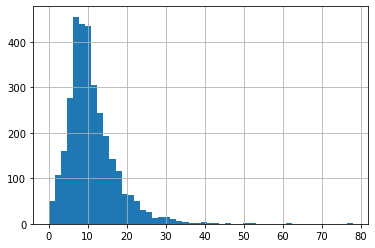

In [74]:
data_gas['gas_amount'].hist(bins = 50)

По газу нет пропущенных величин, распределение величин соответствует нормальному распределению. Ограничим информацию о газе теми партиями, которые мы взяли в работу.

In [75]:
data_gas2  = data_gas.loc[data_gas['key'].isin(final_keys.values)]

In [76]:
data_gas2

key  gas_amount
0        1      29.750
1        2      12.556
2        3      28.555
3        4      18.841
4        5       5.414
...    ...         ...
2492  2495       7.126
2493  2496       9.413
2494  2497       6.272
2495  2498      14.954
2496  2499      11.336

[2475 rows x 2 columns]

Заметим, что и в bulk  и в gas строк стало меньше, чем в нашем final_keys. Информация по некоторым партиям отсутсвовала в исходных данных. Мы ограничим партии наименьшим из общих чисел при объединении таблиц.  

### Исследуем файл с информацией о проволоке.

In [77]:
data_wire

key  Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0        1  60.060     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1        2  96.052     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2        3  91.160     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3        4  89.064     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4        5  89.238   9.115     NaN     NaN     NaN     NaN     NaN     NaN   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
3076  3237  38.089     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238  56.129     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239 143.358     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240  34.070     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241  63.118     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 9  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
3076     NaN  
3077     NaN  
3078     NaN  
3079     NaN  
3080     NaN  

[3081 rows x 10 columns]

In [78]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Значения типа float, более 3000 элементов.  Однако Wire5 появляется  только раз, и можно было бы пожертвовать партиями (key) в которых пропущено более 99% значений. 

In [79]:
data_wire.isna().mean()

key      0.000
Wire 1   0.008
Wire 2   0.650
Wire 3   0.980
Wire 4   0.995
Wire 5   1.000
Wire 6   0.976
Wire 7   0.996
Wire 8   0.994
Wire 9   0.991
dtype: float64

В Проволоках рассмотрено 3081 партий. При этом Wire 4, 5, 7, 8, 9 имеют более 99% пропусков. Уберем Wire_5 который пропущен совсем. 

In [80]:
data_wire2 = data_wire.drop('Wire 5', axis =1)

In [81]:
data_wire2  = data_wire2.loc[data_wire2['key'].isin(final_keys.values)]

In [82]:
data_wire2.describe()

key    Wire 1  Wire 2  Wire 3  Wire 4  Wire 6  Wire 7  Wire 8  \
count 2,373.000 2,349.000 833.000  39.000  12.000  45.000   4.000  13.000   
mean  1,251.101   103.308  50.847 193.183  59.496  50.659   3.703  55.773   
std     716.093    42.606  40.051 100.868  30.805  37.743   3.818  20.236   
min       1.000     1.919   0.030   0.144  24.149   0.137   0.234  45.077   
25%     629.000    74.212  20.207  93.189  38.347  25.054   0.849  46.002   
50%   1,254.000   102.024  40.113 236.973  49.662  40.086   3.045  46.187   
75%   1,869.000   128.934  70.063 277.069  84.756  65.036   5.899  46.280   
max   2,499.000   330.314 282.780 385.009 113.231 180.455   8.490 102.762   

       Wire 9  
count  28.000  
mean   35.099  
std    19.628  
min     4.623  
25%    23.178  
50%    30.085  
75%    44.945  
max    90.054

In [83]:
data_wire2.isna().mean()

key      0.000
Wire 1   0.010
Wire 2   0.649
Wire 3   0.984
Wire 4   0.995
Wire 6   0.981
Wire 7   0.998
Wire 8   0.995
Wire 9   0.988
dtype: float64

Тем не менее, в Wire 1 около 10% пропусков данных. Это значит, что в некоторых ситуациях проволока не добавлялась. Заменим отсутствующие значения на нули.

In [84]:
data_wire2 = data_wire2.fillna(0)

Посмотрим теперь на время добавления проволоки:

In [85]:
data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

In [86]:
#Поскольку в исходных данных мы удалили информацию по проволоке 4, 5, 7, 8, 9, то тут удалим ее тоже

data_wire_time2 = data_wire_time.drop(['Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Wire 9'], axis = 1)

In [87]:
data_wire_time2.isna().mean()

key      0.000
Wire 1   0.008
Wire 2   0.650
Wire 3   0.980
Wire 6   0.976
dtype: float64

In [88]:
#Поскольку существенных пропусков нет только для Wire1 - оставим только время для нее
data_wire_time2 = data_wire_time2[['key', 'Wire 1']]


In [89]:
#Преобразуем данные в дату-время и посмотрим на то, как распределяется время добавленя проволоки
data_wire_time2['Wire 1'] = pd.to_datetime(data_wire_time2['Wire 1'], format = '%Y-%m-%d %H:%M:%S').copy()
data_wire_time2.columns = ['key', 'Wire_1_time']

Фактически, у нас есть информация о времени  о добавления только Wire1, поэтому дальше посмотрим на то, не подозрительно ли время добавления проволоки в разные key.

<AxesSubplot:>

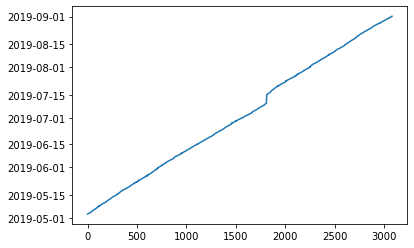

In [90]:
data_wire_time2['Wire_1_time'].plot()

Тут я не могу сказать, как нам поможет знание времени добавления проволоки, тем более, что работает только для одного столбца эта история. Введем эти данные в финальную таблицу и преобразуем во временной промежуток. 

### Консолидируем рабочие данные в единую таблицу

In [91]:
final_data = pd.merge(left = temp_stats_final, right = data_bulk2, how = 'inner', on = 'key')

In [92]:
final_data = pd.merge(left = final_data, right = arc_stat2, how = 'inner', on = 'key')

In [93]:
final_data = pd.merge(left = final_data, right = data_wire2, how = 'inner', on = 'key')

In [94]:
final_data = pd.merge(left = final_data, right = data_gas2, how = 'inner', on = 'key')

In [95]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   key                       2328 non-null   int64          
 1   count                     2328 non-null   int64          
 2   max_time                  2328 non-null   datetime64[ns] 
 3   min_time                  2328 non-null   datetime64[ns] 
 4   final_temperature         2328 non-null   float64        
 5   starting_temperature      2328 non-null   float64        
 6   procedure_time            2328 non-null   timedelta64[ns]
 7   Bulk 1                    2328 non-null   float64        
 8   Bulk 2                    2328 non-null   float64        
 9   Bulk 3                    2328 non-null   float64        
 10  Bulk 4                    2328 non-null   float64        
 11  Bulk 5                    2328 non-null   float64        
 12  Bulk 6

Поскольку мы не берем упоминания времени в этой модели, то удалим df_index, min_time, max_time, procedure_time, heating_first_start_time, а также key.

In [96]:
final_data = final_data.drop(['key', 'min_time', 'max_time' ,'df_index', 'heating_first_start_time', 'procedure_time'], axis = 1)

In [97]:
final_data.isna().mean()

count                  0.000
final_temperature      0.000
starting_temperature   0.000
Bulk 1                 0.000
Bulk 2                 0.000
Bulk 3                 0.000
Bulk 4                 0.000
Bulk 5                 0.000
Bulk 6                 0.000
Bulk 7                 0.000
Bulk 9                 0.000
Bulk 10                0.000
Bulk 11                0.000
Bulk 12                0.000
Bulk 13                0.000
Bulk 14                0.000
Bulk 15                0.000
mean_a_power           0.000
mean_heat_period       0.000
amount_h_periods       0.000
mean_r_power           0.000
Wire 1                 0.000
Wire 2                 0.000
Wire 3                 0.000
Wire 4                 0.000
Wire 6                 0.000
Wire 7                 0.000
Wire 8                 0.000
Wire 9                 0.000
gas_amount             0.000
dtype: float64

In [98]:
final_data['power'] = abs((final_data['mean_a_power']**2 + final_data['mean_r_power']**2)**0.5)

In [99]:
final_data = final_data.drop(['mean_a_power', 'mean_r_power', 'count'], axis = 1)

In [139]:
final_data.describe()

final_temperature  starting_temperature    Bulk 1    Bulk 2    Bulk 3  \
count          2,328.000             2,328.000 2,328.000 2,328.000 2,328.000   
mean           1,593.372             1,586.722     3.429     1.423    47.369   
std               11.199                28.296    12.415    19.086    75.320   
min            1,541.000             1,191.000     0.000     0.000     0.000   
25%            1,587.000             1,571.000     0.000     0.000     0.000   
50%            1,593.000             1,587.000     0.000     0.000     0.000   
75%            1,598.000             1,603.000     0.000     0.000    80.000   
max            1,653.000             1,660.000   185.000   325.000   454.000   

         Bulk 4    Bulk 5    Bulk 6    Bulk 7    Bulk 9   Bulk 10   Bulk 11  \
count 2,328.000 2,328.000 2,328.000 2,328.000 2,328.000 2,328.000 2,328.000   
mean     37.320     2.641    22.381     2.006     0.445     5.055     4.247   
std      58.651    22.407    55.752    30.683     6.222    20.922    22.520   
min       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
50%       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
75%      77.250     0.000     0.000     0.000     0.000     0.000     0.000   
max     281.000   603.000   503.000   772.000   147.000   159.000   313.000   

        Bulk 12   Bulk 13   Bulk 14   Bulk 15  mean_heat_period  \
count 2,328.000 2,328.000 2,328.000 2,328.000         2,328.000   
mean    208.505     1.068   153.835   120.004           172.058   
std     157.037    14.238    81.417    84.622            43.731   
min       0.000     0.000     0.000     0.000            57.000   
25%     105.000     0.000   105.000     0.000           141.000   
50%     206.000     0.000   149.000   107.000           169.500   
75%     282.250     0.000   204.000   204.000           198.750   
max   1,849.000   305.000   636.000   405.000           378.000   

       amount_h_periods    Wire 1    Wire 2    Wire 3    Wire 4    Wire 6  \
count         2,328.000 2,328.000 2,328.000 2,328.000 2,328.000 2,328.000   
mean              4.696   102.455    17.617     3.236     0.307     0.979   
std               1.607    43.546    33.630    27.949     4.759     8.695   
min               1.000     0.000     0.000     0.000     0.000     0.000   
25%               4.000    73.205     0.000     0.000     0.000     0.000   
50%               5.000   101.119     0.000     0.000     0.000     0.000   
75%               6.000   128.097    23.110     0.000     0.000     0.000   
max              16.000   330.314   282.780   385.009   113.231   180.455   

         Wire 7    Wire 8    Wire 9  gas_amount     power  
count 2,328.000 2,328.000 2,328.000   2,328.000 2,328.000  
mean      0.006     0.311     0.317      11.376     0.836  
std       0.206     4.404     3.457       6.393     0.242  
min       0.000     0.000     0.000       0.008     0.228  
25%       0.000     0.000     0.000       7.283     0.660  
50%       0.000     0.000     0.000      10.101     0.814  
75%       0.000     0.000     0.000      14.217     0.985  
max       8.490   102.762    62.026      77.995     1.795

## Вывод и план

На обучение будем подавать датафрейм из 2328 строк, содержащий финальную температуру (ее мы после выделим в целевую характеристику и свойств - количества итераций при обработке стали, времени на полный цикл обработки, характеристиках проволоки и добавок и газа для каждой партии, а также суммарное время работы с партией, среднее время нагрева и прочие).
<br>



**План дальнейших работ**:<br>
1. Выделить features, train
2. Выделить тестовую и обучающую выборку.
3. Выбрать две модели регрессии (catboost и lin_regression)
4. создать скорер для MAE
5. обучить модели и определить кросс-валидацией их параметры.
6. Сравнить параметры с требуемыми и, исходя из этого проверять модель на тестовой выборке или нет. 
7. Написать вывод по работе.
8. Написать отчет для технолога.

## Обучение моделей и оценка точности моделей

### Разделим данные на тестовую выборку и обучающую

In [101]:
#Разделим данные на target/features
target = final_data['final_temperature']
features = final_data.drop(['final_temperature'], axis=1)

In [102]:
#выделим учебну и тестовую выборку
features_valid, features_train, target_valid, target_train = train_test_split(features, target, test_size=0.75, random_state=131222)


In [103]:
print(features_train.shape)
print(features_valid.shape)

(1746, 27)
(582, 27)


### Попробуем линейную регрессию

In [104]:
#Сначала оценим наличие и степень мультиколлинеарности в данных:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [107]:
#проверим данные на зависимость (мультиколлинеарность)
vif_data = pd.DataFrame()
vif_data["feature"] = features_train.columns
vif_data["VIF"] = [variance_inflation_factor(features_train.values, i) for i in range(len(features_train.columns))]

In [108]:
vif_data.loc[vif_data['VIF']>= 10]

feature     VIF
0   starting_temperature  35.648
8                 Bulk 9  19.589
15      mean_heat_period 217.395
16      amount_h_periods  14.272
23                Wire 8  19.624
26                 power 173.752

Если верить (https://towardsdatascience.com/everything-you-need-to-know-about-multicollinearity-2f21f082d6dc), то выраженная мультиколлинеарность соответствует VIF >=10. Это означает, что Bulk 9, температуры, среднее время нагревов, Wire 8 и полная мощность не явлюятся полностью независимыми признаками. Я тут не могу сообразить - имеем ли мы право выбросить их, ведь да, все признаки являются частью одного техпроцесса и зависят друг от друга (особенно нагревы, мощность и температура). Предлагаю оставить признаки, поскольку мультиколлиенарность не испортит саму модель, а только повлияет на ее оценку (MAE).

In [109]:
#Попробуем другой способ оценки корреляции признаков: phik
import phik
from phik.report import plot_correlation_matrix
from phik import report


In [110]:
phik_overview = features_train.phik_matrix()


interval columns not set, guessing: ['starting_temperature', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'mean_heat_period', 'amount_h_periods', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'gas_amount', 'power']


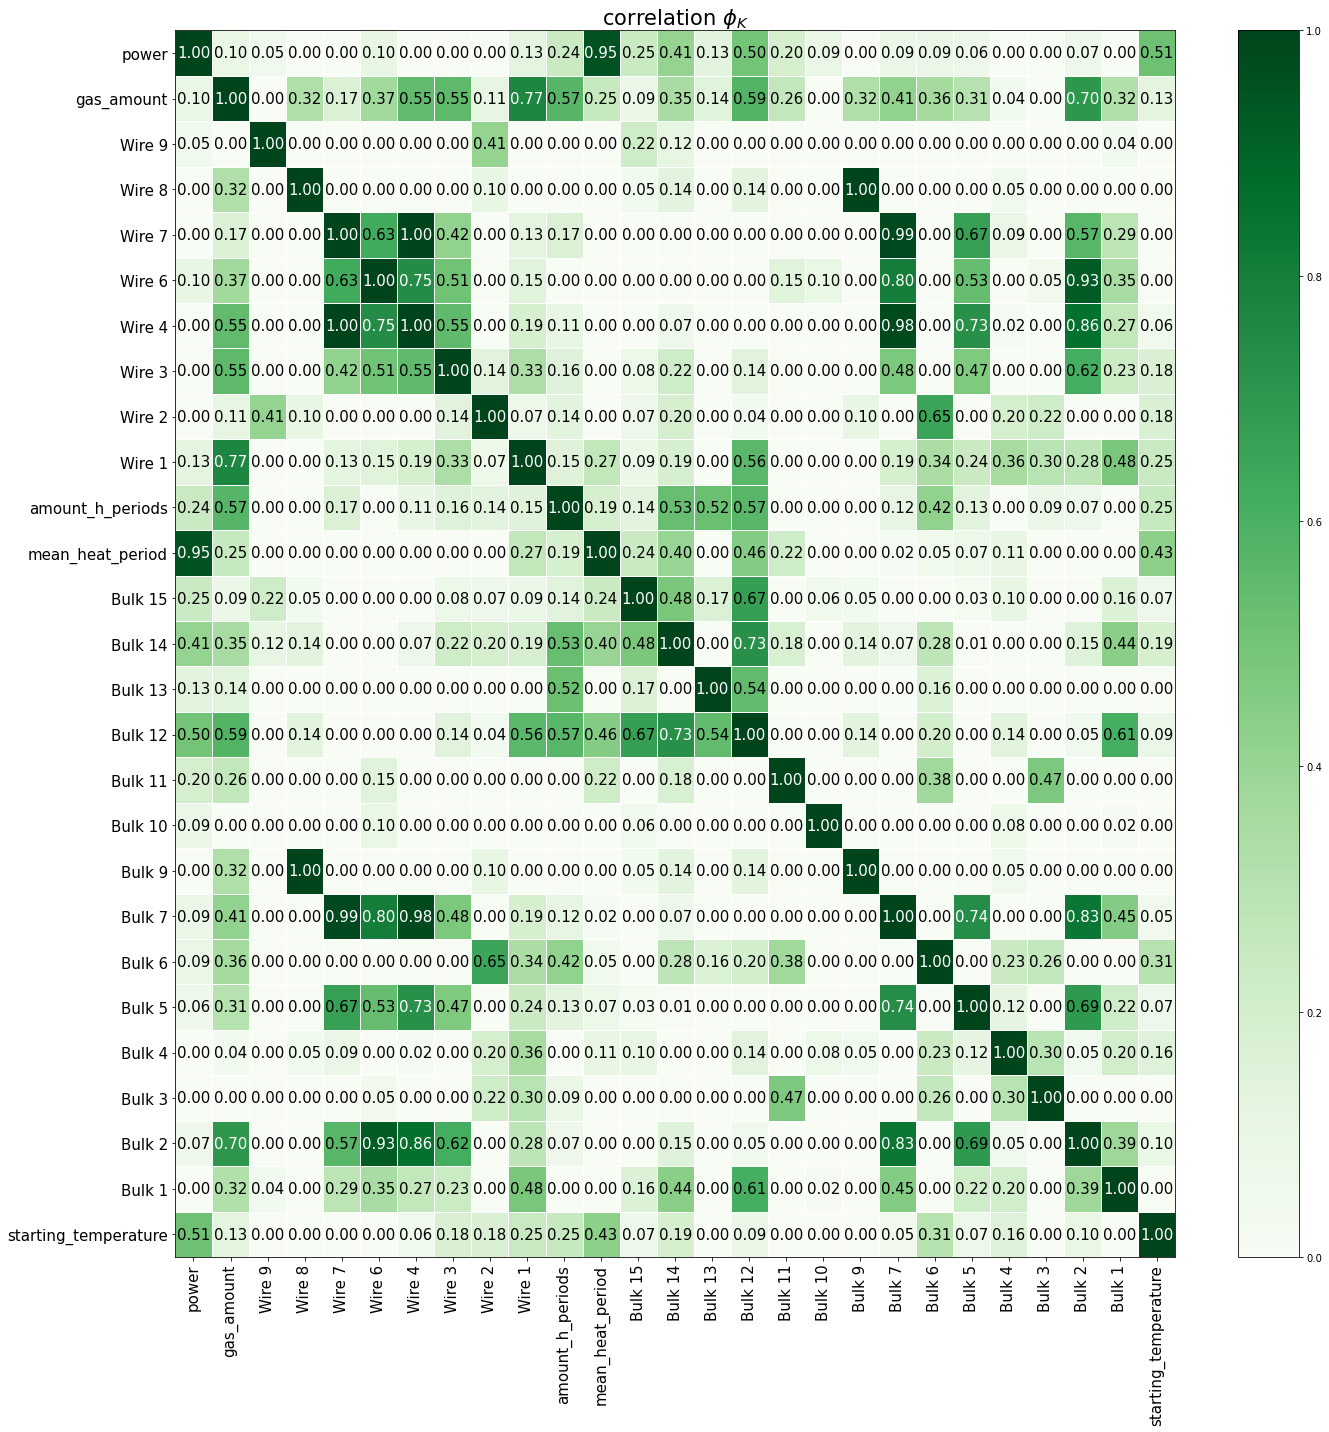

In [111]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 20))
plt.tight_layout()

Здесь более явно видно, что мощность зависит от периода нагрева (что логично), количество нагревов зависит от числа замеров температуры, а некоторые wire и bulk добавляются, видимо, одновременно, и зависят друг от друга. Предлагаю добавки не менять (а вот убрать столбец count)

In [113]:
#Отмасштабируем признаки

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features_train)
features_train_n = scaler.transform(features_train)
features_valid_n = scaler.transform(features_valid) 


In [114]:
#Попробуем модель линейной регрессии

model_l = LinearRegression()

scores = cross_val_score(model_l, features_train_n, target_train, scoring="neg_mean_absolute_error",cv=5) 
final_score = scores.mean()

In [115]:
#Выведем MAE при кросс-валидации?
final_score*-1

6.776644052521258

MAE в 6.77 является приемлемой с точки зрения решения задачи. Однако, это результат на обучающей выборке: на тестовой может быть похуже.

### Попробуем  CatBoostRegressor

In [116]:
model_cat = CatBoostRegressor(iterations =  300, 
          depth =  2,
          loss_function = "MAE",
          verbose =  False,
          learning_rate=0.4)
model_cat.fit(features_train, target_train)

In [117]:
#Посмотрим лучший результат на обучающей выборке
model_cat.get_best_score()

{'learn': {'MAE': 4.619372881103429}}

In [140]:
#посмотрим на оценку CatBoost с кросс-валидацией
params = model_cat.get_params()
cv_dataset = Pool(data=features_train,
                  label=target_train)
scores = cv(cv_dataset,
            params,
            fold_count=3, 
            plot=True, verbose = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 956.4310892	test: 956.7491304	best: 956.7491304 (0)	total: 13.8ms	remaining: 4.11s
1:	learn: 574.1063366	test: 574.4460273	best: 574.4460273 (1)	total: 15.7ms	remaining: 2.34s
2:	learn: 344.6385391	test: 344.9844154	best: 344.9844154 (2)	total: 16.7ms	remaining: 1.65s
3:	learn: 207.1134291	test: 207.4540133	best: 207.4540133 (3)	total: 17.5ms	remaining: 1.3s
4:	learn: 124.5078622	test: 124.8379007	best: 124.8379007 (4)	total: 18.2ms	remaining: 1.07s
5:	learn: 74.9714384	test: 75.2546865	best: 75.2546865 (5)	total: 19.4ms	remaining: 949ms
6:	learn: 45.5862267	test: 45.8733135	best: 45.8733135 (6)	total: 19.9ms	remaining: 832ms
7:	learn: 27.9048741	test: 28.1633313	best: 28.1633313 (7)	total: 20.3ms	remaining: 740ms
8:	learn: 17.4855375	test: 17.7949930	best: 17.7949930 (8)	total: 20.7ms	remaining: 670ms
9:	learn: 11.8673472	test: 12.0096350	best: 12.0096350 (9)	total: 21.4ms	remaining: 619ms
10:	learn: 9.1504242	test: 9.2071603	best: 9.2071603 (10)	total

170:	learn: 4.7300219	test: 6.1160563	best: 6.1160563 (170)	total: 118ms	remaining: 88.8ms
171:	learn: 4.7269372	test: 6.1160800	best: 6.1160563 (170)	total: 119ms	remaining: 88.2ms
172:	learn: 4.7194125	test: 6.1116910	best: 6.1116910 (172)	total: 119ms	remaining: 87.6ms
173:	learn: 4.7122482	test: 6.1145822	best: 6.1116910 (172)	total: 120ms	remaining: 86.8ms
174:	learn: 4.7093322	test: 6.1163026	best: 6.1116910 (172)	total: 120ms	remaining: 86ms
175:	learn: 4.7066904	test: 6.1146311	best: 6.1116910 (172)	total: 123ms	remaining: 86.4ms
176:	learn: 4.7022263	test: 6.1146382	best: 6.1116910 (172)	total: 123ms	remaining: 85.5ms
177:	learn: 4.6955207	test: 6.1154208	best: 6.1116910 (172)	total: 124ms	remaining: 84.7ms
178:	learn: 4.6952855	test: 6.1154562	best: 6.1116910 (172)	total: 124ms	remaining: 83.8ms
179:	learn: 4.6928450	test: 6.1137044	best: 6.1116910 (172)	total: 124ms	remaining: 82.9ms
180:	learn: 4.6903580	test: 6.1045500	best: 6.1045500 (180)	total: 125ms	remaining: 82ms
181

85:	learn: 5.1695620	test: 8.0907944	best: 8.0819228 (81)	total: 38.9ms	remaining: 96.7ms
86:	learn: 5.1551093	test: 8.0952382	best: 8.0819228 (81)	total: 39.7ms	remaining: 97.1ms
87:	learn: 5.1478791	test: 8.0981415	best: 8.0819228 (81)	total: 40.2ms	remaining: 96.8ms
88:	learn: 5.1428156	test: 8.0975603	best: 8.0819228 (81)	total: 40.7ms	remaining: 96.5ms
89:	learn: 5.1241078	test: 8.0871716	best: 8.0819228 (81)	total: 41.1ms	remaining: 95.9ms
90:	learn: 5.1199802	test: 8.0911737	best: 8.0819228 (81)	total: 41.5ms	remaining: 95.2ms
91:	learn: 5.1002792	test: 8.0809007	best: 8.0809007 (91)	total: 41.8ms	remaining: 94.6ms
92:	learn: 5.0924410	test: 8.0783284	best: 8.0783284 (92)	total: 42.2ms	remaining: 93.9ms
93:	learn: 5.0859003	test: 8.0695610	best: 8.0695610 (93)	total: 42.6ms	remaining: 93.3ms
94:	learn: 5.0807114	test: 8.0815568	best: 8.0695610 (93)	total: 42.9ms	remaining: 92.6ms
95:	learn: 5.0736081	test: 8.0884291	best: 8.0695610 (93)	total: 43.3ms	remaining: 92ms
96:	learn: 5

9:	learn: 11.7747282	test: 12.2331289	best: 12.2331289 (9)	total: 5.79ms	remaining: 168ms
10:	learn: 9.2229355	test: 9.5240569	best: 9.5240569 (10)	total: 6.49ms	remaining: 171ms
11:	learn: 8.1138402	test: 8.2886976	best: 8.2886976 (11)	total: 6.94ms	remaining: 167ms
12:	learn: 7.4963626	test: 7.6712646	best: 7.6712646 (12)	total: 7.38ms	remaining: 163ms
13:	learn: 7.1971415	test: 7.3897474	best: 7.3897474 (13)	total: 7.86ms	remaining: 161ms
14:	learn: 7.1117650	test: 7.2977763	best: 7.2977763 (14)	total: 8.27ms	remaining: 157ms
15:	learn: 7.0183496	test: 7.1582677	best: 7.1582677 (15)	total: 8.67ms	remaining: 154ms
16:	learn: 6.8878940	test: 7.1151543	best: 7.1151543 (16)	total: 9.08ms	remaining: 151ms
17:	learn: 6.7378358	test: 7.0587322	best: 7.0587322 (17)	total: 9.62ms	remaining: 151ms
18:	learn: 6.6213539	test: 6.9448515	best: 6.9448515 (18)	total: 10.2ms	remaining: 150ms
19:	learn: 6.5380583	test: 6.8569742	best: 6.8569742 (19)	total: 10.9ms	remaining: 152ms
20:	learn: 6.4814355

Кросс-валидация на CatBoost показывает оценку модели в MAE в районе 6.3. Это результат лучший, чем показатель линейной регрессии. Оценим качество модели CatBoost на тестовой выборке.

## Оценка лучшей модели на тестовой выборке

In [141]:
predictions_cat = model_cat.predict(features_valid)
print(f'Лучший MAE для  CatBoost: {mean_absolute_error(target_valid, predictions_cat)}')

Лучший MAE для  CatBoost: 6.037593507194944


## Оценка важности признаков

In [142]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_valid.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(15,8))
    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

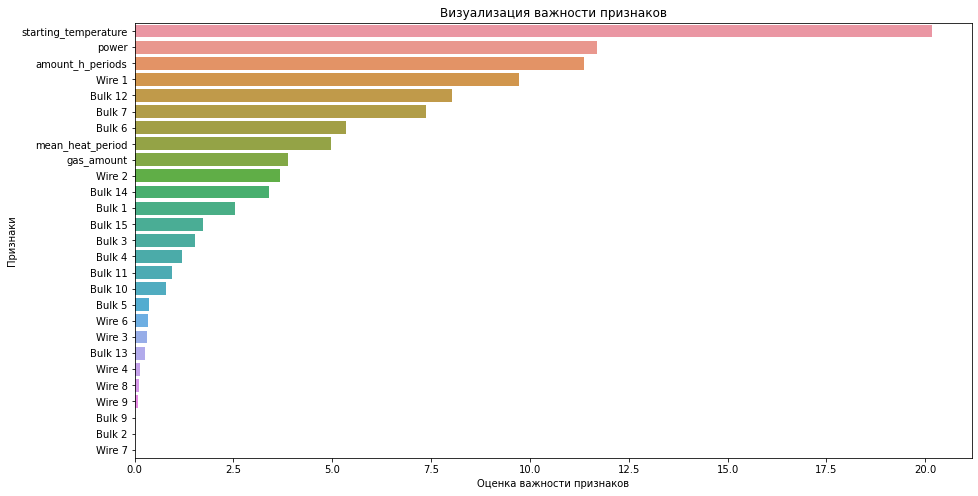

In [143]:
chart_feature_imp(model_cat.fit(features_train, target_train))

Самые важные признаки в нашей выборк в порядке убывания: начальная температура процесса, мощность, количество нагревов, Wire 1, Bulk 12, Bulk 7, Bulk 6, средняя длительность нагрева, объем газа и так далее.

## Вывод

На имеющихся данных была создана модель, позволяющая по исходной температуре стали, количеству смешиваний и добавкам предсказать температуру сплава на финальном этапе. 

Модель CatBoost с параметрами (iterations =  300, depth =  2, loss_function = "MAE", learning_rate=0.4) на тестовой выборке дает значение MAE 6.0, что удоволетворяет поставленной задаче.

Исходные данные для вычисления температуры должны содержать следующие параметры:



In [144]:
features.columns

Index(['starting_temperature', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'mean_heat_period', 'amount_h_periods',
       'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8',
       'Wire 9', 'gas_amount', 'power'],
      dtype='object')

Столбцы означают: 


 - 'count' - число замеров температуры, 
 - 'starting_temperature' - начальная температура стали,

*Легирующие добавки:*

'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'mean_heat_period', 
'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8',
'Wire 9', 
 - 'gas_amount', 
 - 'power' - полная мощность, 
 - 'amount_h_periods' - количество нагревов
